## **1. 라이브러리 설치**

In [ ]:
!pip install koreanize-matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 99.0 MB/s eta 0:00:00


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
from google.colab import files
import os
import zipfile
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import yaml
import shutil
from tqdm import tqdm
from glob import glob
import random
import numpy as np
import torch
from ultralytics import YOLO
from IPython.display import Image, display
import glob
import koreanize_matplotlib
from google.colab import files
from glob import glob
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **2. 시드 고정**
- 재현 가능한 결과를 위해 random, numpy, torch의 시드를 고정한다.
- 이를 통해 매 실행마다 동일한 데이터 셔플링, weight 초기화 등을 보장받을 수 있다.

In [ ]:
random.seed(71)
np.random.seed(71)
torch.manual_seed(71)
torch.cuda.manual_seed(71)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## **3. 데이터 경로 설정**

- Google Drive에서 Colab 환경으로 압축 해제하고, 모델 훈련에 사용할 데이터 경로를 지정한다.

In [ ]:
zip_path = "/content/drive/MyDrive/codeit_level1_project/additional_data.zip"
extract_dir = os.path.dirname(zip_path)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("압축 해제 완료:", extract_dir)

압축 해제 완료: /content/drive/MyDrive/codeit_level1_project


In [ ]:
# 데이터 경로
data_path = '/content/drive/MyDrive/codeit_level1_project/additional_data'
test_dir = '/content/drive/MyDrive/codeit_level1_project/data/test_images'

## **4. 하이퍼파라미터 튜닝**
- YOLOv8x 모델의 성능을 극대화하기 위해 핵심 하이퍼파라미터에 대한 튜닝을 진행하였다.  

- 튜닝은 Ultralytics의 내장 `model.tune()` 기능을 활용하였으며, 아래와 같은 파라미터들을 선택하여 `Random Search` 방식으로 최적 조합을 탐색하였다.

1) 튜닝 설정
- 모델: yolov8x
- 이미지 크기: 640×640
- 튜닝 반복 수 (iterations): 20
- 각 반복의 학습 에폭 수: 30
- 튜닝 방식: Ultralytics 내장 튜너 + 랜덤 서치
- 시드 고정: 71 (재현성 확보)

2) 튜닝에 사용된 하이퍼파라미터

| 하이퍼파라미터 | 범위 | 설명 |
|----------------|------|------|
| `lr0`          | 1e-5 ~ 1e-2 | 초기 학습률. 모델 학습의 수렴 속도와 안정성에 영향 |
| `lrf`          | 0.01 ~ 1.0 | 최종 학습률 계수. 학습 후반부에 학습률이 얼마나 줄어드는지 결정 |
| `momentum`     | 0.8 ~ 0.98 | SGD 옵티마이저의 모멘텀. 수렴 속도와 진동 완화에 영향 |
| `box`          | 0.02 ~ 0.2 | 손실 함수에서 위치(바운딩 박스) 손실 가중치 |
| `cls`          | 0.2 ~ 4.0  | 손실 함수에서 클래스 분류 손실 가중치. 클래스 예측 정확도와 관련 |

> 이러한 파라미터들은 모델의 학습 안정성, 위치 정확도, 클래스 분류 성능에 직접적인 영향을 미치기 때문에, 본 실험에서는 가장 핵심적인 요소만 선별하여 효율적으로 튜닝을 진행하였다.

In [ ]:
model = YOLO("yolov8x.pt")

result_grid = model.tune(
    data='/content/drive/MyDrive/codeit_level1_project/data/data.yaml',
    space={"lr0": (1e-5, 1e-2),
           "lrf": (0.01, 1.0),
           "momentum": (0.8, 0.98),
           "box": (0.02, 0.2),
           "cls": (0.2, 4.0)},
    epochs=30,
    imgsz=640,
    iterations=20,
    seed=71,
    project="/content/drive/MyDrive/codeit_level1_project/yolo8_add_hyp/",
    name="hyp",
)

100%|██████████| 131M/131M [00:02<00:00, 47.2MB/s]


Tuner: Initialized Tuner instance with 'tune_dir=/content/drive/MyDrive/codeit_level1_project/yolo8_add_hyp/hyp'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/20 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'box': 0.2, 'cls': 0.5}
Saved /content/drive/MyDrive/codeit_level1_project/yolo8_add_hyp/hyp/tune_scatter_plots.png
Saved /content/drive/MyDrive/codeit_level1_project/yolo8_add_hyp/hyp/tune_fitness.png

Tuner: 1/20 iterations complete ✅ (1168.08s)
Tuner: Results saved to /content/drive/MyDrive/codeit_level1_project/yolo8_add_hyp/hyp
Tuner: Best fitness=0.96712 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.9832, 'metrics/recall(B)': 0.98426, 'metrics/mAP50(B)': 0.97966, 'metrics/mAP50-95(B)': 0.96572, 'val/box_loss': 0.00626, 'val/cls_loss': 0.1708, 'val/dfl_loss': 0.81723, 'fitness': 0.96712}
Tuner: Best fitness model is /content/drive/MyDrive/codeit_lev

## **4. YOLOv8x 모델 훈련 및 검증**

### 4.1 모델 구성 및 학습 실행
- 기존에는 경량화된 YOLOv8n 모델을 사용해 빠른 학습이 가능했지만, 더 높은 검출 성능(mAP)을 위해 YOLOv8x (Extra-large) 모델로 실험을 확장하였다.
- 아래는 Ultralytics에서 제공한 YOLOv8 계열 모델들의 성능 비교표이다.

| 모델          | 크기 (픽셀) | mAPval 50-95 | CPU 속도 (ms) | A100 속도 (ms) | 매개변수 (M) | FLOPs (B) |
| ----------- | ------- | ------------ | ----------- | ------------ | -------- | --------- |
| YOLOv8n     | 640     | 37.3         | 80.4        | 0.99         | 3.2      | 8.7       |
| YOLOv8s     | 640     | 44.9         | 128.4       | 1.20         | 11.2     | 28.6      |
| YOLOv8m     | 640     | 50.2         | 234.7       | 1.83         | 25.9     | 78.9      |
| YOLOv8l     | 640     | 52.9         | 375.2       | 2.39         | 43.7     | 165.2     |
| **YOLOv8x** | 640     | **53.9**     | 479.1       | 3.53         | 68.2     | 257.8     |


> YOLOv8x는 가장 높은 mAP 성능(53.9)을 기록하며, 성능 중심 실험에 적합하다. 단점은 속도와 자원 요구량이 상대적으로 크다는 점이다.

In [ ]:
model = YOLO("yolov8x.pt")
model.info()

In [ ]:
# YAML에서 하이퍼파라미터 로드
hyp_path = "/content/drive/MyDrive/codeit_level1_project/yolo8_add_hyp/hyp/best_hyperparameters.yaml"
with open(hyp_path, 'r') as f:
    hyp_params = yaml.safe_load(f)

- 성능 향상을 위해 에폭 수는 100으로 설정하였으며,
제한된 GPU 환경을 고려하여 배치 사이즈는 16으로 조정하였다.
- 또한, 실험 결과의 재현성 확보를 위해 시드는 71로 고정하였다.

In [ ]:
# 학습 실행
results = model.train(
    data='/content/drive/MyDrive/codeit_level1_project/data/data.yaml',
    epochs=100,
    imgsz=640,
    batch=16,
    device=0,
    cache=True,
    seed=71,
    project="/content/drive/MyDrive/codeit_level1_project/yolo8_add_hyp/",
    name="train_result",
    **hyp_params
)

Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=0.2, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.4652, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/codeit_level1_project/data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8x.pt, momentum=0.98, mosaic=1.0, multi_scale=False, name=train_result, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, 

train: Scanning /content/drive/MyDrive/codeit_level1_project/additional_data/labels/train.cache... 1484 images, 0 backgrounds, 3 corrupt: 100%|██████████| 1484/1484 [00:00<?, ?it/s]

train: /content/drive/MyDrive/codeit_level1_project/additional_data/images/train/K-003351-016262-018357_0_2_0_2_75_000_200.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     6.8878]
train: /content/drive/MyDrive/codeit_level1_project/additional_data/images/train/K-003544-012247-016548-029451_0_2_0_2_90_000_200.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     2.1211]
train: /content/drive/MyDrive/codeit_level1_project/additional_data/images/train/K-006563-012247-016551-024850_0_2_0_2_70_000_200.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     5.8352]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (1.3GB RAM): 100%|██████████| 1481/1481 [00:11<00:00, 128.49it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 265.7±108.7 MB/s, size: 1702.9 KB)


val: Scanning /content/drive/MyDrive/codeit_level1_project/additional_data/labels/val.cache... 579 images, 0 backgrounds, 2 corrupt: 100%|██████████| 579/579 [00:00<?, ?it/s]

val: /content/drive/MyDrive/codeit_level1_project/additional_data/images/val/K-012420-016548-024850-029451_0_2_0_2_75_000_200.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1419      2.0318]
val: /content/drive/MyDrive/codeit_level1_project/additional_data/images/val/K-012420-016551-021771-031705_0_2_0_2_70_000_200.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     2.3945      4.6352]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.5GB RAM): 100%|██████████| 577/577 [00:03<00:00, 169.53it/s]


Plotting labels to /content/drive/MyDrive/codeit_level1_project/yolo8_add_hyp/train_result/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.98' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00013, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/codeit_level1_project/yolo8_add_hyp/train_result
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      11.8G    0.01793      2.082      1.061         74        640: 100%|██████████| 93/93 [00:21<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.88it/s]

                   all        577       2308      0.966      0.944      0.972      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      13.3G    0.01041     0.6396     0.8948         76        640: 100%|██████████| 93/93 [00:20<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.19it/s]

                   all        577       2308      0.973       0.97      0.975      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      13.4G    0.01034     0.5173     0.8938         71        640: 100%|██████████| 93/93 [00:19<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.10it/s]

                   all        577       2308      0.972      0.978      0.972      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      13.4G    0.01026     0.4527     0.8851         44        640: 100%|██████████| 93/93 [00:19<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.17it/s]

                   all        577       2308      0.981      0.984      0.975       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      13.4G    0.01039     0.4164     0.8936         80        640: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.15it/s]

                   all        577       2308      0.981      0.983      0.977      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      13.5G   0.009853     0.3828      0.888         77        640: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.15it/s]

                   all        577       2308       0.98      0.983      0.976      0.949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      14.1G   0.009596     0.3643     0.8821         44        640: 100%|██████████| 93/93 [00:19<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.22it/s]

                   all        577       2308      0.982      0.981      0.976       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      14.1G   0.009655     0.3359     0.8833         69        640: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.18it/s]

                   all        577       2308      0.982      0.984      0.974      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      14.1G   0.009255     0.3206     0.8735         59        640: 100%|██████████| 93/93 [00:19<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.19it/s]

                   all        577       2308      0.981       0.98      0.976      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      14.1G   0.009109     0.3196     0.8729         67        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.19it/s]

                   all        577       2308      0.982      0.979      0.977      0.949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      14.1G   0.009118     0.3051     0.8744         70        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.12it/s]

                   all        577       2308      0.982      0.984      0.976      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      14.1G   0.008744     0.2935     0.8699         59        640: 100%|██████████| 93/93 [00:19<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.21it/s]

                   all        577       2308      0.982      0.984      0.978      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      14.1G   0.009039     0.2929     0.8701         69        640: 100%|██████████| 93/93 [00:19<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.22it/s]

                   all        577       2308      0.982      0.984       0.98      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      14.1G   0.009054     0.2791     0.8735         58        640: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.24it/s]

                   all        577       2308      0.982      0.984      0.978      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      14.1G   0.008779     0.2798     0.8682         61        640: 100%|██████████| 93/93 [00:19<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.11it/s]

                   all        577       2308      0.983      0.984      0.981      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      14.1G   0.008449     0.2646     0.8643         74        640: 100%|██████████| 93/93 [00:19<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.26it/s]

                   all        577       2308      0.983      0.984      0.979      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      14.1G   0.008606     0.2658      0.868         70        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.24it/s]

                   all        577       2308      0.983      0.984      0.979      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      14.1G   0.008488     0.2601     0.8627         73        640: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.17it/s]

                   all        577       2308      0.983      0.984       0.98       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      14.1G   0.008546     0.2575     0.8632         77        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.23it/s]

                   all        577       2308      0.982      0.984       0.98      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      14.1G   0.008323     0.2507     0.8622         41        640: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.23it/s]

                   all        577       2308      0.976      0.984       0.98      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      14.1G   0.008303      0.252     0.8645         58        640: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.26it/s]

                   all        577       2308      0.982      0.984      0.979      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      14.1G   0.008308     0.2518     0.8648         73        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.27it/s]

                   all        577       2308      0.979      0.973      0.977      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      14.1G   0.008119      0.241     0.8603         58        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.21it/s]

                   all        577       2308      0.982      0.984      0.979      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      14.1G   0.008056     0.2392     0.8607         69        640: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.27it/s]

                   all        577       2308      0.982      0.984      0.979       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      14.1G   0.008034     0.2323     0.8594         43        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.25it/s]

                   all        577       2308      0.983      0.984      0.978      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      14.1G   0.007891     0.2274      0.857         59        640: 100%|██████████| 93/93 [00:19<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.23it/s]

                   all        577       2308      0.983      0.983      0.978      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      14.1G   0.008052     0.2396     0.8574         57        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.26it/s]

                   all        577       2308      0.983      0.984      0.978      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      14.1G   0.007864     0.2305     0.8565         61        640: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.26it/s]

                   all        577       2308      0.982      0.983      0.978      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      14.1G   0.007777      0.226     0.8557         99        640: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.19it/s]

                   all        577       2308      0.984      0.984       0.98       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      14.1G   0.007752     0.2207     0.8512         53        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.93it/s]

                   all        577       2308      0.984      0.985      0.978      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      14.1G   0.007799     0.2234     0.8573         67        640: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.20it/s]

                   all        577       2308      0.983      0.984      0.979      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      14.1G   0.007741     0.2181     0.8538         85        640: 100%|██████████| 93/93 [00:19<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.13it/s]

                   all        577       2308      0.979      0.983      0.979      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      14.1G   0.008002     0.2232     0.8617         67        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.21it/s]

                   all        577       2308      0.983      0.984      0.979      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      14.1G   0.007784     0.2187     0.8539         51        640: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.23it/s]

                   all        577       2308      0.983      0.984       0.98      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      14.1G     0.0078     0.2268     0.8546         66        640: 100%|██████████| 93/93 [00:19<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.21it/s]

                   all        577       2308      0.983      0.982      0.979       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      14.1G    0.00776     0.2209      0.857         68        640: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.22it/s]

                   all        577       2308      0.983      0.984      0.979      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      14.1G    0.00773     0.2155     0.8541         52        640: 100%|██████████| 93/93 [00:19<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.21it/s]

                   all        577       2308      0.983      0.984      0.978       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      14.1G   0.007405     0.2027     0.8509         70        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.25it/s]

                   all        577       2308      0.983      0.984      0.979      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      14.1G   0.007396     0.2129     0.8525         67        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.23it/s]

                   all        577       2308      0.984      0.984       0.98      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      14.1G   0.007383     0.2125     0.8512         63        640: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.11it/s]

                   all        577       2308      0.983      0.984      0.978      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      14.1G   0.007471     0.2078     0.8502         71        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.17it/s]

                   all        577       2308      0.984      0.985      0.979      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      14.1G   0.007405     0.2029     0.8514         59        640: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.18it/s]

                   all        577       2308      0.984      0.984      0.978      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      14.1G   0.007532     0.2076     0.8523         63        640: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.25it/s]

                   all        577       2308      0.984      0.984       0.98      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      14.1G   0.007325     0.2033     0.8488         51        640: 100%|██████████| 93/93 [00:19<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.25it/s]

                   all        577       2308      0.983      0.983      0.979      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      14.1G   0.007306     0.2029     0.8454         55        640: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.24it/s]

                   all        577       2308      0.984      0.984      0.978      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      14.1G   0.007292     0.2043     0.8502         47        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.28it/s]

                   all        577       2308      0.982      0.984      0.979      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      14.1G   0.007295     0.1989     0.8465         65        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.26it/s]

                   all        577       2308      0.984      0.985      0.979      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      14.1G   0.007148     0.2017     0.8469         51        640: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.22it/s]

                   all        577       2308      0.983      0.984      0.979      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      14.1G   0.007174     0.1986     0.8458         61        640: 100%|██████████| 93/93 [00:19<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.21it/s]

                   all        577       2308      0.984      0.985       0.98      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      14.1G   0.007198      0.196     0.8499         64        640: 100%|██████████| 93/93 [00:19<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.26it/s]

                   all        577       2308      0.983      0.985      0.979      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      14.1G   0.007129     0.1952     0.8433         79        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.23it/s]

                   all        577       2308      0.984      0.985      0.978      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      14.1G   0.007093     0.1898     0.8395         68        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.26it/s]

                   all        577       2308      0.983      0.984      0.977      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      14.1G   0.006967     0.1907     0.8397         67        640: 100%|██████████| 93/93 [00:19<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.19it/s]

                   all        577       2308      0.984      0.984      0.979      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      14.1G   0.007033     0.1894      0.843         55        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.10it/s]

                   all        577       2308      0.982      0.984      0.979      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      14.1G   0.007054     0.1935     0.8447         74        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.20it/s]

                   all        577       2308      0.984      0.984       0.98      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      14.1G   0.006917     0.1869     0.8423         62        640: 100%|██████████| 93/93 [00:19<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.25it/s]

                   all        577       2308      0.984      0.985       0.98      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      14.1G   0.007021      0.192     0.8471         66        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.20it/s]

                   all        577       2308      0.984      0.984      0.978      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      14.1G   0.006997     0.1888     0.8459         53        640: 100%|██████████| 93/93 [00:19<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.23it/s]

                   all        577       2308      0.983      0.984      0.979      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      14.1G   0.006833     0.1825     0.8408         76        640: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.26it/s]

                   all        577       2308      0.984      0.984      0.981       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      14.1G   0.006755     0.1823     0.8391         51        640: 100%|██████████| 93/93 [00:19<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.26it/s]

                   all        577       2308      0.984      0.985      0.978      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      14.1G   0.006905     0.1875     0.8489         84        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.29it/s]

                   all        577       2308      0.983      0.984      0.978      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      14.1G   0.006806     0.1854     0.8418         61        640: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.12it/s]

                   all        577       2308      0.982      0.984      0.979      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      14.1G   0.006889      0.189     0.8402         60        640: 100%|██████████| 93/93 [00:19<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.22it/s]

                   all        577       2308      0.982      0.985       0.98      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      14.1G    0.00668     0.1788     0.8368         41        640: 100%|██████████| 93/93 [00:19<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.25it/s]

                   all        577       2308      0.983      0.984       0.98      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      14.1G   0.006615     0.1766     0.8373         68        640: 100%|██████████| 93/93 [00:19<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.27it/s]

                   all        577       2308      0.984      0.984       0.98      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      14.1G   0.006588     0.1774     0.8365         73        640: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.27it/s]

                   all        577       2308      0.984      0.984      0.981      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      14.1G   0.006693     0.1815     0.8424         60        640: 100%|██████████| 93/93 [00:19<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.24it/s]

                   all        577       2308      0.984      0.984       0.98      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      14.1G   0.006506     0.1756     0.8345         52        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.26it/s]

                   all        577       2308      0.984      0.984       0.98      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      14.1G   0.006477      0.173     0.8396         62        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.24it/s]

                   all        577       2308      0.984      0.984      0.978      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      14.1G   0.006546     0.1744     0.8362         68        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.19it/s]

                   all        577       2308      0.984      0.984      0.978      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      14.1G   0.006421     0.1707       0.84         62        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.19it/s]

                   all        577       2308      0.984      0.984      0.979      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      14.1G   0.006452     0.1733     0.8408         80        640: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.18it/s]

                   all        577       2308      0.983      0.984       0.98      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      14.1G   0.006301     0.1671     0.8351         77        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.25it/s]

                   all        577       2308      0.984      0.984      0.978      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      14.1G   0.006348     0.1661     0.8372         58        640: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.22it/s]

                   all        577       2308      0.983      0.984       0.98       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      14.1G   0.006229     0.1637     0.8325         66        640: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.27it/s]

                   all        577       2308      0.983      0.984       0.98      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      14.1G    0.00617     0.1627     0.8344         95        640: 100%|██████████| 93/93 [00:19<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.23it/s]

                   all        577       2308      0.983      0.984      0.981      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      14.1G   0.006143     0.1627     0.8301         62        640: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.23it/s]

                   all        577       2308      0.984      0.984      0.981      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      14.1G   0.006189     0.1636     0.8339         69        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.23it/s]

                   all        577       2308      0.984      0.984       0.98      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      14.1G    0.00623     0.1619     0.8349         55        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.24it/s]

                   all        577       2308      0.984      0.984       0.98      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      14.1G   0.006164     0.1591      0.833         60        640: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.21it/s]

                   all        577       2308      0.984      0.984      0.981      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      14.1G    0.00606     0.1562     0.8285         64        640: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.27it/s]

                   all        577       2308      0.984      0.984      0.979      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      14.1G   0.006014     0.1528      0.832         62        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.19it/s]

                   all        577       2308      0.984      0.984      0.981       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      14.1G    0.00604     0.1576     0.8284         80        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.12it/s]

                   all        577       2308      0.984      0.984       0.98       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      14.1G    0.00603     0.1561     0.8323         57        640: 100%|██████████| 93/93 [00:19<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.19it/s]

                   all        577       2308      0.984      0.984      0.979      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      14.1G   0.005975      0.154     0.8303         85        640: 100%|██████████| 93/93 [00:19<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.24it/s]

                   all        577       2308      0.984      0.984      0.979       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      14.1G   0.005997     0.1532     0.8282         88        640: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.29it/s]

                   all        577       2308      0.984      0.984      0.978      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      14.1G   0.005954     0.1545     0.8308         60        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.27it/s]

                   all        577       2308      0.983      0.984      0.979       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      14.1G   0.005815     0.1519     0.8297         51        640: 100%|██████████| 93/93 [00:19<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.27it/s]

                   all        577       2308      0.984      0.984      0.979      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      14.1G   0.005834     0.1521     0.8268         61        640: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.25it/s]

                   all        577       2308      0.984      0.984      0.979      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      14.1G   0.005799     0.1457     0.8297         60        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.22it/s]

                   all        577       2308      0.984      0.984      0.979       0.97


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      14.1G   0.004928     0.1218      0.801         35        640: 100%|██████████| 93/93 [00:20<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.19it/s]

                   all        577       2308      0.983      0.984      0.981      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      14.1G   0.004894     0.1213     0.8002         36        640: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.19it/s]

                   all        577       2308      0.983      0.984      0.981      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      14.1G   0.004793     0.1185     0.7992         33        640: 100%|██████████| 93/93 [00:19<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.20it/s]

                   all        577       2308      0.983      0.984       0.98      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      14.1G   0.004797     0.1181     0.8003         36        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.26it/s]

                   all        577       2308      0.983      0.984       0.98      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      14.1G   0.004803      0.118     0.7982         33        640: 100%|██████████| 93/93 [00:19<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.26it/s]

                   all        577       2308      0.984      0.984       0.98      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      14.1G   0.004739     0.1178     0.7977         36        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.23it/s]

                   all        577       2308      0.984      0.984      0.979       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      14.1G   0.004802     0.1197     0.7986         35        640: 100%|██████████| 93/93 [00:19<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.18it/s]

                   all        577       2308      0.983      0.984      0.979       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      14.1G   0.004666     0.1143     0.7986         36        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.22it/s]

                   all        577       2308      0.983      0.984      0.979      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      14.1G   0.004637     0.1132     0.7987         33        640: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.20it/s]

                   all        577       2308      0.984      0.984      0.979       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      14.1G   0.004649     0.1132     0.7972         36        640: 100%|██████████| 93/93 [00:19<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.28it/s]

                   all        577       2308      0.984      0.984      0.979       0.97



100 epochs completed in 0.712 hours.
Optimizer stripped from /content/drive/MyDrive/codeit_level1_project/yolo8_add_hyp/train_result/weights/last.pt, 136.9MB
Optimizer stripped from /content/drive/MyDrive/codeit_level1_project/yolo8_add_hyp/train_result/weights/best.pt, 136.9MB

Validating /content/drive/MyDrive/codeit_level1_project/yolo8_add_hyp/train_result/weights/best.pt...
Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 112 layers, 68,193,867 parameters, 0 gradients, 257.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.95it/s]


                   all        577       2308      0.984      0.984       0.98      0.972
            쎄로켈정 100mg        162        162      0.992      0.994      0.995      0.987
           아빌리파이정 10mg        206        206      0.985      0.985      0.983      0.968
          자이프렉사정 2.5mg        209        209       0.99       0.99      0.992      0.989
           가바토파정 100mg        269        269      0.988      0.989      0.981      0.979
         동아가바펜틴정 800mg        308        308      0.974      0.974      0.968      0.965
        란스톤엘에프디티정 30mg         89         89      0.987      0.989      0.992      0.971
             스토가정 10mg         86         86      0.988      0.988      0.992      0.992
          펠루비정(펠루비프로펜)         91         91      0.944      0.945      0.919      0.919
            라비에트정 20mg        101        101       0.98       0.98      0.973       0.97
              놀텍정 10mg        102        102       0.99       0.99      0.987       0.97
             울트라셋이알서방

### 4.2 검증 데이터 성능 평가
- YOLOv8x 모델에 대해 5개의 하이퍼파라미터를 튜닝한 결과, 성능이 가장 우수한 설정값을 적용하여 학습을 수행하였다.
- 그 후, 튜닝된 모델의 최적 가중치(best.pt)를 이용해 검증 데이터셋(577장, 2,308개 객체)에 대한 성능 평가를 진행하였다.
- 하이퍼파라미터 튜닝을 적용한 결과, 모든 주요 지표에서 매우 우수한 성능을 확인하였다.

| 항목            | 값     |
| ------------- | ----- |
| Precision     | 0.984 |
| Recall        | 0.984 |
| mAP\@0.5      | 0.980 |
| mAP\@0.5:0.95 | 0.972 |
| 검증 이미지 수      | 577장  |
| 총 객체 수        | 2308개 |


In [ ]:
model = YOLO("/content/drive/MyDrive/codeit_level1_project/yolo8_add_hyp/train_result/weights/best.pt")
metrics = model.val()
print(metrics.box)

Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 112 layers, 68,193,867 parameters, 0 gradients, 257.8 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 613.5±49.7 MB/s, size: 1708.7 KB)


val: Scanning /content/drive/MyDrive/codeit_level1_project/additional_data/labels/val.cache... 579 images, 0 backgrounds, 2 corrupt: 100%|██████████| 579/579 [00:00<?, ?it/s]

val: /content/drive/MyDrive/codeit_level1_project/additional_data/images/val/K-012420-016548-024850-029451_0_2_0_2_75_000_200.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1419      2.0318]
val: /content/drive/MyDrive/codeit_level1_project/additional_data/images/val/K-012420-016551-021771-031705_0_2_0_2_70_000_200.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     2.3945      4.6352]



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:08<00:00,  4.41it/s]


                   all        577       2308      0.984      0.984       0.98      0.972
            쎄로켈정 100mg        162        162      0.992      0.994      0.994      0.987
           아빌리파이정 10mg        206        206      0.985      0.985      0.984       0.97
          자이프렉사정 2.5mg        209        209       0.99       0.99      0.992      0.989
           가바토파정 100mg        269        269      0.988      0.989      0.981       0.98
         동아가바펜틴정 800mg        308        308      0.974      0.974      0.968      0.965
        란스톤엘에프디티정 30mg         89         89      0.987      0.989      0.991       0.97
             스토가정 10mg         86         86      0.988      0.988      0.993      0.992
          펠루비정(펠루비프로펜)         91         91      0.944      0.945       0.92       0.92
            라비에트정 20mg        101        101       0.98       0.98      0.973      0.971
              놀텍정 10mg        102        102       0.99       0.99      0.987      0.973
             울트라셋이알서방

## **5. 모델 평가**

### 5.1 테스트 이미지 예측
- 학습이 완료된 YOLOv8x 모델의 최적 가중치(best.pt)를 사용하여, 테스트 이미지에 대한 객체 탐지 예측을 수행하였다.

In [ ]:
model = YOLO("/content/drive/MyDrive/codeit_level1_project/yolo8_add_hyp/train_result/weights/best.pt")
results = model.predict(
    source=test_dir,
    imgsz=640,
    conf=0.25,
    save=True,
    project="/content/drive/MyDrive/codeit_level1_project/yolo8_add_hyp/",
    name="test_result",
    exist_ok=True
)


image 1/843 /content/drive/MyDrive/codeit_level1_project/data/test_images/1.png: 640x512 1 보령부스파정 5mg, 1 동아가바펜틴정 800mg, 1 놀텍정 10mg, 1 울트라셋이알서방정, 57.6ms
image 2/843 /content/drive/MyDrive/codeit_level1_project/data/test_images/10.png: 640x512 1 보령부스파정 5mg, 1 가바토파정 100mg, 1 라비에트정 20mg, 1 레일라정, 13.0ms
image 3/843 /content/drive/MyDrive/codeit_level1_project/data/test_images/100.png: 640x512 1 보령부스파정 5mg, 1 가바토파정 100mg, 1 란스톤엘에프디티정 30mg, 1 신바로정, 13.1ms
image 4/843 /content/drive/MyDrive/codeit_level1_project/data/test_images/1003.png: 640x512 1 기넥신에프정(은행엽엑스)(수출용), 1 리피토정 20mg, 1 트윈스타정 40/5mg, 1 제미메트서방정 50/1000mg, 13.0ms
image 5/843 /content/drive/MyDrive/codeit_level1_project/data/test_images/1004.png: 640x512 1 기넥신에프정(은행엽엑스)(수출용), 1 리피토정 20mg, 1 트윈스타정 40/5mg, 1 제미메트서방정 50/1000mg, 13.0ms
image 6/843 /content/drive/MyDrive/codeit_level1_project/data/test_images/1005.png: 640x512 1 기넥신에프정(은행엽엑스)(수출용), 1 리피토정 20mg, 1 트윈스타정 40/5mg, 1 제미메트서방정 50/1000mg, 13.1ms
image 7/843 /content/drive/MyDriv

### 5.2 예측 결과 시각화
- 시각화 결과, 바운딩 박스와 클래스 라벨 모두 명확히 검출되었으며, 시각화된 이미지에서 모델의 탐지 정확도가 높음을 확인할 수 있다.

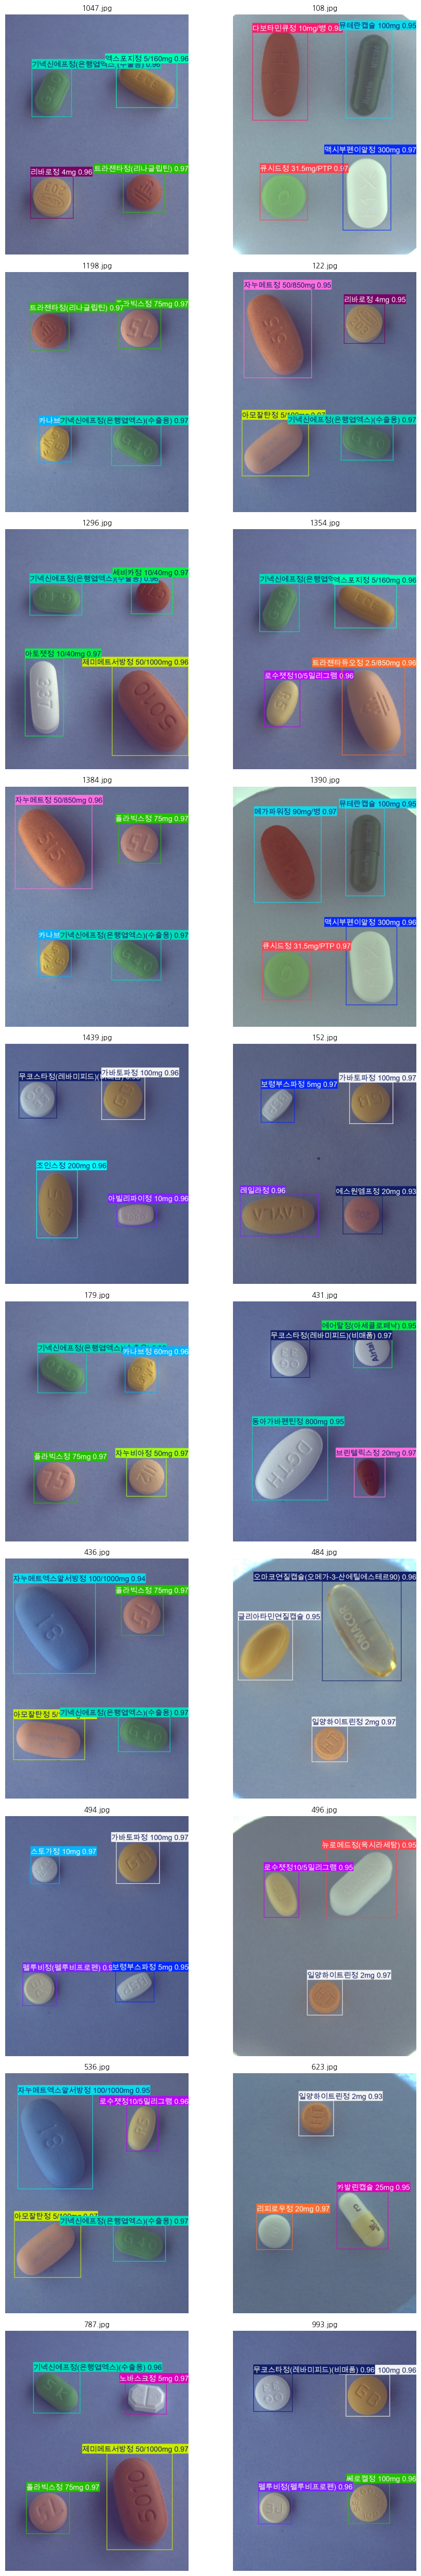

In [ ]:
def visualize_predictions(predict_dir, num_samples=20, cols=4):
    if not os.path.exists(predict_dir):
        raise FileNotFoundError(f"예측 디렉토리 '{predict_dir}'가 존재하지 않습니다.")

    # 이미지 목록 필터링
    image_files = [f for f in os.listdir(predict_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    if len(image_files) == 0:
        raise ValueError("해당 디렉토리에 시각화할 이미지 파일이 없습니다.")

    # 무작위 샘플 선택 (정렬 추가)
    sample_images = sorted(random.sample(image_files, min(num_samples, len(image_files))))

    rows = (len(sample_images) + cols - 1) // cols
    plt.figure(figsize=(cols * 5, rows * 5), dpi=100)

    for i, filename in enumerate(sample_images):
        img_path = os.path.join(predict_dir, filename)
        try:
            img = Image.open(img_path).convert("RGB")
            img.thumbnail((800, 800))
        except Exception as e:
            print(f"이미지 로딩 오류: {filename} → {e}")
            continue

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(filename, fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_predictions("/content/drive/MyDrive/codeit_level1_project/yolo8_add_hyp/test_result", num_samples=20, cols=2)

## **6. 제출 csv 파일 생성**

- 모델의 예측 결과를 기반으로 Kaggle 제출 포맷에 맞는 csv 파일을 생성한다.
- test_images 폴더의 이미지 파일명은 중간중간 누락된 번호가 많기 때문에, 단순한 순번(1, 2, 3...)이 아닌, 파일명에서 추출한 실제 숫자 ID를 그대로 사용해야 한다.
- 클래스 번호는 제출 시 반드시 주어진 category_id와 정확히 매핑해야 평가가 올바르게 이루어진다.


In [ ]:
# 클래스 매핑 로드
with open("/content/drive/MyDrive/codeit_level1_project/data/classid_to_categoryid.json", "r") as f:
    class_to_category = json.load(f)
    class_to_category = {int(k): v for k, v in class_to_category.items()}

# 결과 파싱 및 저장
rows = []
annotation_id = 1

for result in results:
    # image_id: 원본 이미지 경로에서 파일명 숫자 추출
    filename = result.path.split("/")[-1]
    image_id = int(filename.split(".")[0])

    boxes = result.boxes
    if boxes is None or boxes.xywh is None:
        continue

    for i in range(len(boxes.xywh)):
        x, y, w, h = boxes.xywh[i].tolist()
        score = float(boxes.conf[i])
        cls = int(boxes.cls[i])
        category_id = class_to_category.get(cls, -1)

        if category_id == -1:
            continue  # 매핑 실패한 클래스는 제외

        # COCO 포맷: x_min, y_min, width, height
        xmin = round(x - w / 2)
        ymin = round(y - h / 2)
        bbox_w = round(w)
        bbox_h = round(h)

        rows.append([
            annotation_id,
            image_id,
            category_id,
            xmin,
            ymin,
            bbox_w,
            bbox_h,
            round(score, 2)
        ])
        annotation_id += 1

# CSV 저장
df = pd.DataFrame(rows, columns=[
    "annotation_id", "image_id", "category_id",
    "bbox_x", "bbox_y", "bbox_w", "bbox_h", "score"
])
csv_path = "/content/drive/MyDrive/codeit_level1_project/yolo8_add_hyp/submission_yolo8_add.csv"
df.to_csv(csv_path, index=False)
print(f"제출 파일 저장됨: {csv_path} (총 {len(df)}개 bounding box 포함)")

제출 파일 저장됨: /content/drive/MyDrive/codeit_level1_project/yolo8_add_hyp/submission_yolo8_add.csv (총 3238개 bounding box 포함)
